# Coursework II: Intrinsic Time Trading Strategy

I will split this coursework into different segments. 

Part 1: 
- First, I need to import the tick-by-tick data from the excel file and convert it into intrinsic time. 
- Second, write a trading strategy based on the intrinsic time framework and loosely inspired by the alpha-engine strategy mentioned in the lectures.

Part 2:
- First, create a backtest function and a function to visualise the strategy's results.
- Second, create and execute a function to import different FX datasets, convert to intrinsic time, backtest and visualise teh results. 
- Finally I will write a conclusion and discuss the results


-------------------------------------------------------------------

## Part 1: Trading Strategy

First I will import the tick-by-tick data, convert it into intrinsic time and visualise the results.

### Step 1: Import Libraries

Pandas, NumPy and MatPlotLib libraries are commonly used and externally accessible.

The script uses pandas to read data from Excel files in .xlsx format. Pandas relies on the openpyxl package to handle modern Excel files. It's a dependency that pandas requires specifically for Excel file operations, so it needs to be installed before running the script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### Step 2: Load the data


In [2]:
FILE_PATH = r"C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURGBP_M1_2023.xlsx"  
DATA_COLUMN = 3  # zero-indexed, so 4th column


def load_data():
    # Load Excel file
    df = pd.read_excel(FILE_PATH)
    
    # Extract price series from the 4th column
    price_series = df.iloc[:, DATA_COLUMN].values
    return price_series, df

### Step 3: Convert to intrinsic time

Convert the "clock time" data to tick-by-tick "intrinsic time" data using the algorithm described in Lecture 8.

First I need to set parameters that serve as threshold values that determine when significant price movements occur.

- DELTA_UP: How much the price needs to rise to trigger an "up" event when in "down" mode
- DELTA_DOWN: How much the price needs to fall to trigger a "down" event when in "up" mode

In [3]:
DELTA_UP = 0.00025      # Delta threshold for up mode in pips
DELTA_DOWN = 0.00025    # Delta threshold for down mode in pips

def convert_to_intrinsic_time(price_series):
    # Initialise variables
    s_tick = price_series
    s_ext = s_tick[0]
    s_ie = s_tick[0]
    mode = "up"  # Start in up mode
    
    # Lists to store results
    intrinsic_events = []
    event_prices = []
    event_indices = []
    event_modes = []
    
    # First tick is always an event
    intrinsic_events.append(0)
    event_prices.append(s_tick[0])
    event_indices.append(0)
    event_modes.append(mode)
    
    # Intrinsic Time Conversion
    for i in range(1, len(s_tick)):
        # Current tick price
        current_price = s_tick[i]
        
        if mode == "up":
            if current_price - s_ext >= DELTA_UP:
                # Mode change to down
                mode = "down"
                s_ext = current_price
                s_ie = current_price
                intrinsic_events.append(1)
                event_prices.append(current_price)
                event_indices.append(i)
                event_modes.append(mode)
            elif current_price < s_ext:
                s_ext = current_price
                if s_ie - s_ext >= DELTA_DOWN:
                    s_ie = current_price
                    intrinsic_events.append(-2)
                    event_prices.append(current_price)
                    event_indices.append(i)
                    event_modes.append(mode)
                else:
                    intrinsic_events.append(0)
                    event_prices.append(current_price)
                    event_indices.append(i)
                    event_modes.append(mode)
        elif mode == "down":
            if s_ext - current_price >= DELTA_DOWN:
                # Mode change to up
                mode = "up"
                s_ext = current_price
                s_ie = current_price
                intrinsic_events.append(-1)
                event_prices.append(current_price)
                event_indices.append(i)
                event_modes.append(mode)
            elif current_price > s_ext:
                s_ext = current_price
                if s_ext - s_ie >= DELTA_UP:
                    s_ie = current_price
                    intrinsic_events.append(2)
                    event_prices.append(current_price)
                    event_indices.append(i)
                    event_modes.append(mode)
                else:
                    intrinsic_events.append(0)
                    event_prices.append(current_price)
                    event_indices.append(i)
                    event_modes.append(mode)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'index': event_indices,
        'price': event_prices,
        'event': intrinsic_events,
        'mode': event_modes
    })
    
    # Filter out non-events (zeros)
    non_zero_results = results[results['event'] != 0]
    
    return results, non_zero_results

### Step 4: Visualise intrinsic time data

In [4]:
def visualize_intrinsic_time(price_series, all_events_df, non_zero_events_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    
    # Plot 1: Original price series only
    ax1.plot(price_series, color='blue', linewidth=1.5)
    ax1.set_title('Original Price Series', fontsize=14)
    ax1.set_ylabel('Price', fontsize=12)
    
    # Plot 2: Price with only mode changes (events 1 and -1)
    ax2.plot(price_series, color='gray', alpha=0.5, linewidth=1.5)
    
    # Only plot mode changes (events 1 and -1)
    mode_changes = non_zero_events_df[non_zero_events_df['event'].isin([1, -1])]
    
    # Up to Down mode changes (event 1)
    up_to_down = mode_changes[mode_changes['event'] == 1]
    if not up_to_down.empty:
        ax2.scatter(up_to_down['index'], up_to_down['price'], 
                   color='green', s=3, label='Up → Down')
    
    # Down to Up mode changes (event -1)
    down_to_up = mode_changes[mode_changes['event'] == -1]
    if not down_to_up.empty:
        ax2.scatter(down_to_up['index'], down_to_up['price'], 
                   color='red', s=1, label='Down → Up')
    
    ax2.set_title('Intrinsic Time Mode Changes', fontsize=14)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Price', fontsize=12)
    if not mode_changes.empty:
        ax2.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

### Step 5: Execute the above code

Finally to execute the above functions i will combine them neatly in one fuunction.

C:\Users\pc\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\pc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


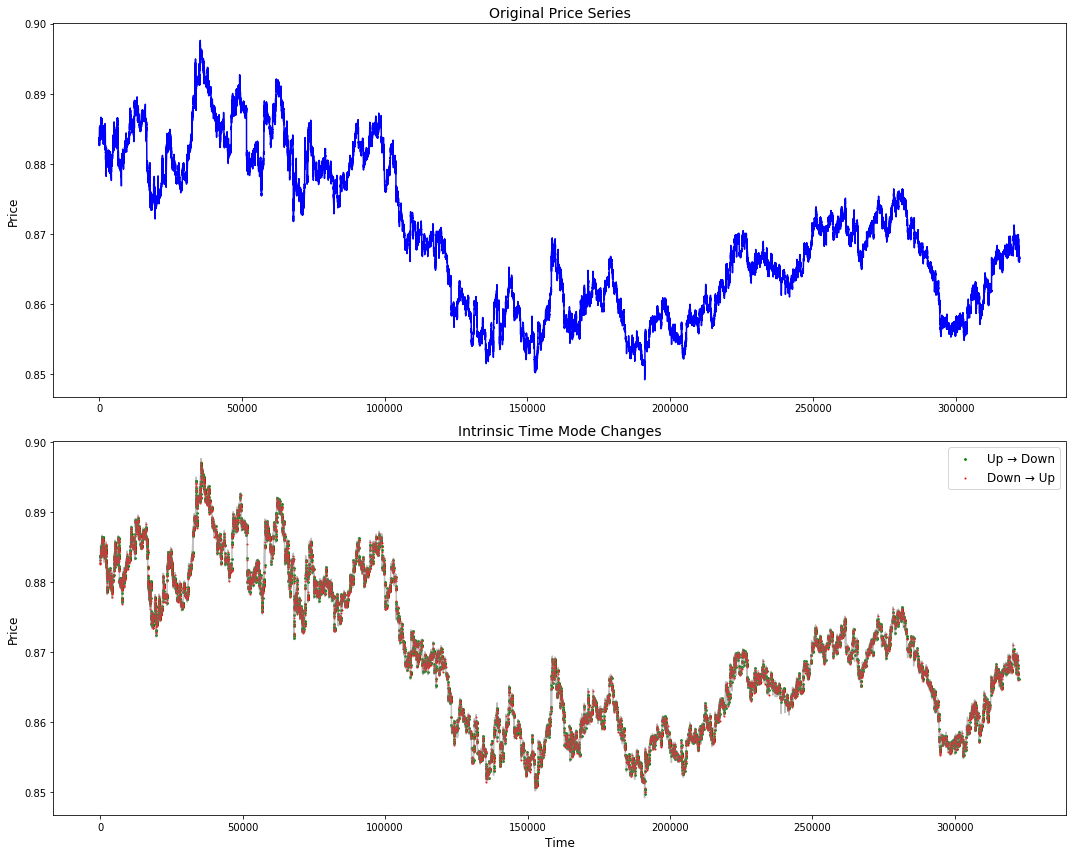

In [5]:
def main():
    # Load data
    price_series, original_df = load_data()
    
    # Convert to intrinsic time
    all_events_df, non_zero_events_df = convert_to_intrinsic_time(price_series)
    
    # Visualize intrinsic time conversion
    visualize_intrinsic_time(price_series, all_events_df, non_zero_events_df)

if __name__ == "__main__":
    main()

- The top subplot plots the original price series as a blue line.

- The bottom subplot shows the same price series as a gray line in the background.
- "Mode changes" in the intrinsic time algorithm are identified as: 
        - green dots for "Up → Down" mode changes (event 1)
        - red dots for "Down → Up" mode changes (event -1)


This visualisation shows exactly when the algorithm switches between "up" and "down" modes in relation to the original price data, which is crucial for understanding how the intrinsic time algorithm works.

### Step 6: Design a trading strategy

#### In Simple Words:

The mean reversion strategy works on the principle that prices tend to return to their average or "mean" after moving significantly in one direction. In my simple example:

- The strategy looks for consecutive downward moves in price, which are detected as "down events" in the intrinsic time conversion.
- After seeing a specific number of consecutive down events (e.g., 3), it buys, expecting the price to bounce back up.
- Similarly, after seeing a specific number of consecutive up events, it sells or "goes short", expecting the price to fall back down.
- The trade is exited either when a profit target is reached (after a set number of events), or when a stop loss is triggered (if the price continues moving against expectations).

#### In Pseudocode: 

FUNCTION meanReversionStrategy(events):
    
    position = NONE
    upCount = 0
    downCount = 0
    
    FOR EACH event IN events:
        # Track consecutive events
        IF event is positive:
            upCount += 1
            downCount = 0
        ELSE IF event is negative:
            downCount += 1
            upCount = 0
        
        # Entry conditions
        IF no position AND downCount >= THRESHOLD:
            BUY
            position = LONG
            
        IF no position AND upCount >= THRESHOLD:
            SELL
            position = SHORT
        
        # Exit conditions
        IF LONG position:
            IF time since entry >= TAKE_PROFIT_TIME:
                CLOSE position
            
            IF upCount >= STOP_LOSS_EVENTS:
                CLOSE position
                
        IF SHORT position:
            IF time since entry >= TAKE_PROFIT_TIME:
                CLOSE position
            
            IF downCount >= STOP_LOSS_EVENTS:
                CLOSE position
    
    # Close any remaining position
    IF position is not NONE:
        CLOSE position
        
    RETURN results

In [6]:
def apply_trading_strategy(intrinsic_events_df, original_df):
    # Initialise tracking variables
    position = 0  # 0: no position, 1: long position, -1: short position
    consecutive_up_events = 0
    consecutive_down_events = 0
    entry_price = 0
    entry_index = 0
    
    trades = []
    
    # Iterate through intrinsic events
    for i in range(1, len(intrinsic_events_df)):
        current_event = intrinsic_events_df.iloc[i]['event']
        current_price = intrinsic_events_df.iloc[i]['price']
        current_index = intrinsic_events_df.iloc[i]['index']
        
        # Track consecutive events with "+="
        if current_event > 0:  # Positive event
            consecutive_up_events += 1
            consecutive_down_events = 0
        elif current_event < 0:  # Negative event
            consecutive_down_events += 1
            consecutive_up_events = 0
        
        # Implement mean eversion - buy after down events, sell after up events
        
        # Long position
        if position == 0 and consecutive_down_events >= BUY_EVENTS_COUNT:
            # Check if the move exceeds threhshold parameter
            if abs(current_price - intrinsic_events_df.iloc[i-BUY_EVENTS_COUNT+1]['price']) >= EVENT_DELTA_MIN:
                # Enter long 
                position = 1
                entry_price = current_price
                entry_index = current_index
                trades.append({
                    'type': 'buy',
                    'entry_index': current_index,
                    'entry_price': current_price,
                    'reason': f'{BUY_EVENTS_COUNT} consecutive down events'
                })
        
        # Short position
        elif position == 0 and consecutive_up_events >= SELL_EVENTS_COUNT:
            # Check if the move exceeds threshold parameter
            if abs(current_price - intrinsic_events_df.iloc[i-SELL_EVENTS_COUNT+1]['price']) >= EVENT_DELTA_MIN:
                # Enter short 
                position = -1
                entry_price = current_price
                entry_index = current_index
                trades.append({
                    'type': 'sell',
                    'entry_index': current_index,
                    'entry_price': current_price,
                    'reason': f'{SELL_EVENTS_COUNT} consecutive up events'
                })
        
        # Take profit for long position
        if position == 1 and len(trades) > 0 and trades[-1]['type'] == 'buy' and 'exit_index' not in trades[-1]:
            if i - intrinsic_events_df[intrinsic_events_df['index'] == trades[-1]['entry_index']].index[0] >= TAKE_PROFIT_EVENTS:
                # Close position
                position = 0
                exit_price = current_price
                trades[-1].update({
                    'exit_index': current_index,
                    'exit_price': current_price,
                    'profit_pct': (exit_price - entry_price) / entry_price * 100,
                    'reason': 'take profit'
                })
        
        # Take profit for shor
        if position == -1 and len(trades) > 0 and trades[-1]['type'] == 'sell' and 'exit_index' not in trades[-1]:
            if i - intrinsic_events_df[intrinsic_events_df['index'] == trades[-1]['entry_index']].index[0] >= TAKE_PROFIT_EVENTS:
                # Close position with profit
                position = 0
                exit_price = current_price
                trades[-1].update({
                    'exit_index': current_index,
                    'exit_price': current_price,
                    'profit_pct': (entry_price - exit_price) / entry_price * 100,  # Reverse for short
                    'reason': 'take profit'
                })
        
        # Stop loss for long position - consecutive up events
        if position == 1 and consecutive_up_events >= STOP_LOSS_EVENTS and len(trades) > 0 and trades[-1]['type'] == 'buy' and 'exit_index' not in trades[-1]:
            # Close position
            position = 0
            exit_price = current_price
            trades[-1].update({
                'exit_index': current_index,
                'exit_price': current_price,
                'profit_pct': (exit_price - entry_price) / entry_price * 100,
                'reason': 'stop loss'
            })
        
        # Stop loss for short position - consecutive down events
        if position == -1 and consecutive_down_events >= STOP_LOSS_EVENTS and len(trades) > 0 and trades[-1]['type'] == 'sell' and 'exit_index' not in trades[-1]:
            # Close position 
            position = 0
            exit_price = current_price
            trades[-1].update({
                'exit_index': current_index,
                'exit_price': current_price,
                'profit_pct': (entry_price - exit_price) / entry_price * 100,  # Reverse for short
                'reason': 'stop loss'
            })
    
    # Close any open positions at the end
    if position != 0 and trades and 'exit_price' not in trades[-1]:
        last_price = intrinsic_events_df.iloc[-1]['price']
        last_index = intrinsic_events_df.iloc[-1]['index']
        
        if position == 1:  # Long position
            trades[-1].update({
                'exit_index': last_index,
                'exit_price': last_price,
                'profit_pct': (last_price - trades[-1]['entry_price']) / trades[-1]['entry_price'] * 100,
                'reason': 'end of data'
            })
        elif position == -1:  # Short position
            trades[-1].update({
                'exit_index': last_index,
                'exit_price': last_price,
                'profit_pct': (trades[-1]['entry_price'] - last_price) / trades[-1]['entry_price'] * 100,
                'reason': 'end of data'
            })
    
    return pd.DataFrame(trades) if trades else pd.DataFrame()


The key aspect of this strategy is that it "fades" or trades against the recent price movement, betting that the trend will reverse. It's well-suited for range-bound markets but would likely struggle in strongly trending markets.

------------------------------------------------------------------

## Part 2: Testing the strategy

Now to backtest the strategy with the following steps:
- Setup parameters for the strategy that are easily adjustable. 
- Create a backtesting function that goes through the intrinsic time data and records when a trade should be initiated and closed.
- Create a function that takes in different data sets and backtests them.
- Present, visualise and discuss results

### Step 1: Set Parameters

#### Intrinsic Time Parameters:

- DELTA_UP: How much the price needs to rise to trigger an "up" event when in "down" mode
- DELTA_DOWN: How much the price needs to fall to trigger a "down" event when in "up" mode

#### Trading Strategy Parameters:

- BUY_EVENTS_COUNT: How many consecutive down events are needed to trigger a buy
- SELL_EVENTS_COUNT: How many consecutive up events are needed to trigger a sell
- EVENT_DELTA_MIN: The minimum price movement needed during those events to consider taking a trade
- TAKE_PROFIT_EVENTS: How many events to wait before closing a profitable trade
- STOP_LOSS_EVENTS: How many consecutive events in the wrong direction to trigger a stop loss

#### Backtesting Parameters:

- INITIAL_CAPITAL: How much money start with in the backtest
- POSITION_SIZE_PCT: What percentage of capital to use for each trade

These parameters control both how price data is converted to intrinsic time and how the trading strategy behaves. You can adjust them to fit different market conditions and trading preferences.

In [7]:
# Intrinsic time parameters
DELTA_UP = 0.00025      # Delta threshold for up mode in pips
DELTA_DOWN = 0.00025    # Delta threshold for down mode in pips

# Trading strategy parameters
BUY_EVENTS_COUNT = 3     # Number of consecutive DOWN events to trigger buy
SELL_EVENTS_COUNT = 3    # Number of consecutive UP events to trigger sell
EVENT_DELTA_MIN = 0.0007    # Minimum delta to consider for signal
TAKE_PROFIT_EVENTS = 7   # Number of consecutive events to wait before taking profit
STOP_LOSS_EVENTS = 5     # Number of consecutive opposite events for stop loss

# Backtesting parameters
INITIAL_CAPITAL = 10000  # Starting capital
POSITION_SIZE_PCT = 50  # Percentage of capital to use per trade

# Transaction costs
SPREAD_PIPS = 1.0       # Average spread in pips
PIP_VALUE = 0.00001      
COMMISSION_PER_TRADE = 5  # Fixed commission per trade in currency units (if applicable)
SLIPPAGE_PIPS = 0     # FX markets are very liquid so should have zero slippage

### Step 2: Create a backtesting function

The backtesting function takes the strategy's decisions and simulates how they would have performed with real money. Here's what it does in simple steps:

1. It starts with a set initial capital.


2. For each trade:
   - It calculates how much money to put into the trade (percentage of current capital)
   - For buy trades: it calculates profit as (exit price - entry price) × number of shares
   - For short trades: it calculates profit as (entry price - exit price) × number of shares


3. After each trade, it:
   - Updates the total capital by adding the profit or loss
   - Records this information to track PnL over time


4. It returns a complete history of the portfolio value after each trade, which is then used to create the performance chart and calculate statistics like total return.

In [8]:
def backtest_strategy(trades_df):
    if trades_df.empty:
        return pd.DataFrame({'index': [0], 'capital': [INITIAL_CAPITAL]})
    
    # Initialize capital and portfolio
    capital = INITIAL_CAPITAL
    portfolio = []  
    trading_active = True  # Flag to track to open new trades
    
    # Backtest each trade
    for i, trade in trades_df.iterrows():
        # Skip opening new trades if capital is depleted, but continue tracking
        if not trading_active:
            portfolio.append({
                'index': i,
                'capital': 0,
                'profit_loss': 0,
                'amount': 0,
                'transaction_cost': 0
            })
            continue
        
        # Calculate position size
        position_size = capital * POSITION_SIZE_PCT
        
        # Calculate transaction costs in currency units
        spread_cost = SPREAD_PIPS * PIP_VALUE * position_size / trade['entry_price']
        slippage_cost = SLIPPAGE_PIPS * PIP_VALUE * position_size / trade['entry_price']
        total_transaction_cost = spread_cost + slippage_cost + COMMISSION_PER_TRADE
        
        # Adjust entry price to account for slippage and spread
        adjusted_entry_price = trade['entry_price']
        if trade['type'] == 'buy':
            adjusted_entry_price += (SPREAD_PIPS + SLIPPAGE_PIPS) * PIP_VALUE
        else:  # sell/short
            adjusted_entry_price -= (SPREAD_PIPS + SLIPPAGE_PIPS) * PIP_VALUE
        
        # Calculate number of shares/units
        amount = position_size / adjusted_entry_price
        
        # Adjust exit price for slippage
        adjusted_exit_price = trade['exit_price']
        if trade['type'] == 'buy':
            adjusted_exit_price -= SLIPPAGE_PIPS * PIP_VALUE  # Sell at a slightly lower price
        else:  # sell/short
            adjusted_exit_price += SLIPPAGE_PIPS * PIP_VALUE  # Buy back at a slightly higher price
        
        # Calculate profit/loss based on trade type with transaction costs
        if trade['type'] == 'buy':
            profit_loss = amount * (adjusted_exit_price - adjusted_entry_price) - total_transaction_cost
        else:  # sell/short
            profit_loss = amount * (adjusted_entry_price - adjusted_exit_price) - total_transaction_cost
        
        # Update capital
        capital += profit_loss
        
        # Check if capital is depleted
        if capital <= 0:
            print(f"Trading halted after trade {i} due to capital depletion")
            capital = 0  # Floor at zero to prevent negative values
            trading_active = False  # Disable further trading
        
        # Record portfolio state
        portfolio.append({
            'index': i,
            'entry_index': trade['entry_index'],
            'exit_index': trade['exit_index'],
            'capital': capital,
            'profit_loss': profit_loss,
            'amount': amount,
            'transaction_cost': total_transaction_cost
        })
    
    return pd.DataFrame(portfolio)

### Step 3: Visualisation

Create a function to take the results from the backtesting function and turn them into charts to illustrate results. 

In [9]:
def visualize_trading_results(price_series, intrinsic_events_df, trades_df, portfolio_df):
    """Simplified visualization of trading strategy results"""
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [1.5, 1, 1]})
    
    # Plot 1: Price with Buy/Sell points
    axes[0].plot(price_series, color='blue', alpha=0.7, linewidth=1.5)
    
    # Add trade entries and exits
    if not trades_df.empty:
        # Buy entries and exits
        buy_trades = trades_df[trades_df['type'] == 'buy']
        if not buy_trades.empty:
            axes[0].scatter(buy_trades['entry_index'], buy_trades['entry_price'], 
                           marker='^', color='green', s=50, label='Buy Entry')
            
            if 'exit_index' in buy_trades.columns:
                axes[0].scatter(buy_trades['exit_index'], buy_trades['exit_price'], 
                               marker='v', color='blue', s=50, label='Buy Exit')
        
        # Sell entries and exits
        sell_trades = trades_df[trades_df['type'] == 'sell']
        if not sell_trades.empty:
            axes[0].scatter(sell_trades['entry_index'], sell_trades['entry_price'], 
                           marker='v', color='red', s=50, label='Sell Entry')
            
            if 'exit_index' in sell_trades.columns:
                axes[0].scatter(sell_trades['exit_index'], sell_trades['exit_price'], 
                               marker='^', color='orange', s=50, label='Sell Exit')
    
    axes[0].set_title('Price Series with Trades', fontsize=14)
    axes[0].set_ylabel('Price', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    
    # Plot 2: Trade Outcomes
    if not trades_df.empty and 'profit_pct' in trades_df.columns:
        profits = trades_df['profit_pct'].values
        colors = ['green' if p > 0 else 'red' for p in profits]
        
        axes[1].bar(range(len(profits)), profits, color=colors, width=0.7)
        
        
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].set_title('Trade Performance (% Returns)', fontsize=14)
        axes[1].set_xlabel('Trade Number', fontsize=12)
        axes[1].set_ylabel('Return (%)', fontsize=12)
    else:
        axes[1].text(0.5, 0.5, 'No trades executed', ha='center', va='center', 
                    transform=axes[1].transAxes, fontsize=12)
    
    # Plot 3: Portfolio Value
    if not portfolio_df.empty:
        axes[2].plot(portfolio_df['index'], portfolio_df['capital'], 
                    marker='o', linestyle='-', color='purple', linewidth=2)
        
        # Calculate total return
        total_return = ((portfolio_df['capital'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100
        
        axes[2].set_title('Portfolio Value', fontsize=14)
        axes[2].set_xlabel('Trade Number', fontsize=12)
        axes[2].set_ylabel('Capital ($)', fontsize=12)
        
        # Add simple text box with return
        axes[2].text(0.02, 0.95, f'Total Return: {total_return:.2f}%', 
                    transform=axes[2].transAxes, fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.7))
    else:
        axes[2].text(0.5, 0.5, 'No portfolio data', ha='center', va='center', 
                    transform=axes[2].transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
# =============================================
# PRINT SUMMARY
# =============================================
def print_summary(trades_df, portfolio_df):
    print(f"\n{'='*50}")
    print("MEAN REVERSION TRADING STRATEGY SUMMARY")
    print(f"{'='*50}")
    print(f"Total Trades: {len(trades_df)}")
    
    if not trades_df.empty and 'profit_pct' in trades_df.columns:
        # trade statistics
        win_trades = trades_df[trades_df['profit_pct'] > 0]
        lose_trades = trades_df[trades_df['profit_pct'] <= 0]
        
        print(f"Winning Trades: {len(win_trades)} ({len(win_trades)/len(trades_df)*100:.2f}%)")
        print(f"Average Win: {win_trades['profit_pct'].mean():.2f}%" if not win_trades.empty else "Average Win: N/A")
        print(f"Losing Trades: {len(lose_trades)} ({len(lose_trades)/len(trades_df)*100:.2f}%)")
        print(f"Average Loss: {lose_trades['profit_pct'].mean():.2f}%" if not lose_trades.empty else "Average Loss: N/A")
        
        # Buy trades
        buy_trades = trades_df[trades_df['type'] == 'buy']
        if not buy_trades.empty:
            buy_wins = buy_trades[buy_trades['profit_pct'] > 0]
            print(f"\nBuy Trades: {len(buy_trades)}")
            print(f"Buy Win Rate: {len(buy_wins)/len(buy_trades)*100:.2f}%" if not buy_trades.empty else "Buy Win Rate: N/A")
            print(f"Average Buy Profit: {buy_trades['profit_pct'].mean():.2f}%")
        
        # Sell trades
        sell_trades = trades_df[trades_df['type'] == 'sell']
        if not sell_trades.empty:
            sell_wins = sell_trades[sell_trades['profit_pct'] > 0]
            print(f"\nSell Trades: {len(sell_trades)}")
            print(f"Sell Win Rate: {len(sell_wins)/len(sell_trades)*100:.2f}%" if not sell_trades.empty else "Sell Win Rate: N/A")
            print(f"Average Sell Profit: {sell_trades['profit_pct'].mean():.2f}%")
    
    if not portfolio_df.empty:
        print(f"\nMaximum Drawdown: ${INITIAL_CAPITAL - portfolio_df['capital'].min():.2f}")
        final_capital = portfolio_df['capital'].iloc[-1] if len(portfolio_df) > 0 else INITIAL_CAPITAL
        print(f"Starting Capital: ${INITIAL_CAPITAL:.2f}")
        print(f"Final Capital: ${final_capital:.2f}")
        print(f"Total Return: {((final_capital / INITIAL_CAPITAL) - 1) * 100:.2f}%")
    
    print(f"{'='*50}")


### Step 4: Process and backtest multiple datasets

This final function acts as a conductor, orchestrating the entire workflow by sequentially calling the previously  described data loading, intrinsic time conversion, strategy application, backtesting and visualisation functions in this script for each excel file. 

It repeats this process for each excel file listed. This is useful because it tests the strategy on multiple files without having to manually run the script for each one.


PROCESSING C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURAUD_M1_2023.xlsx


C:\Users\pc\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\pc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


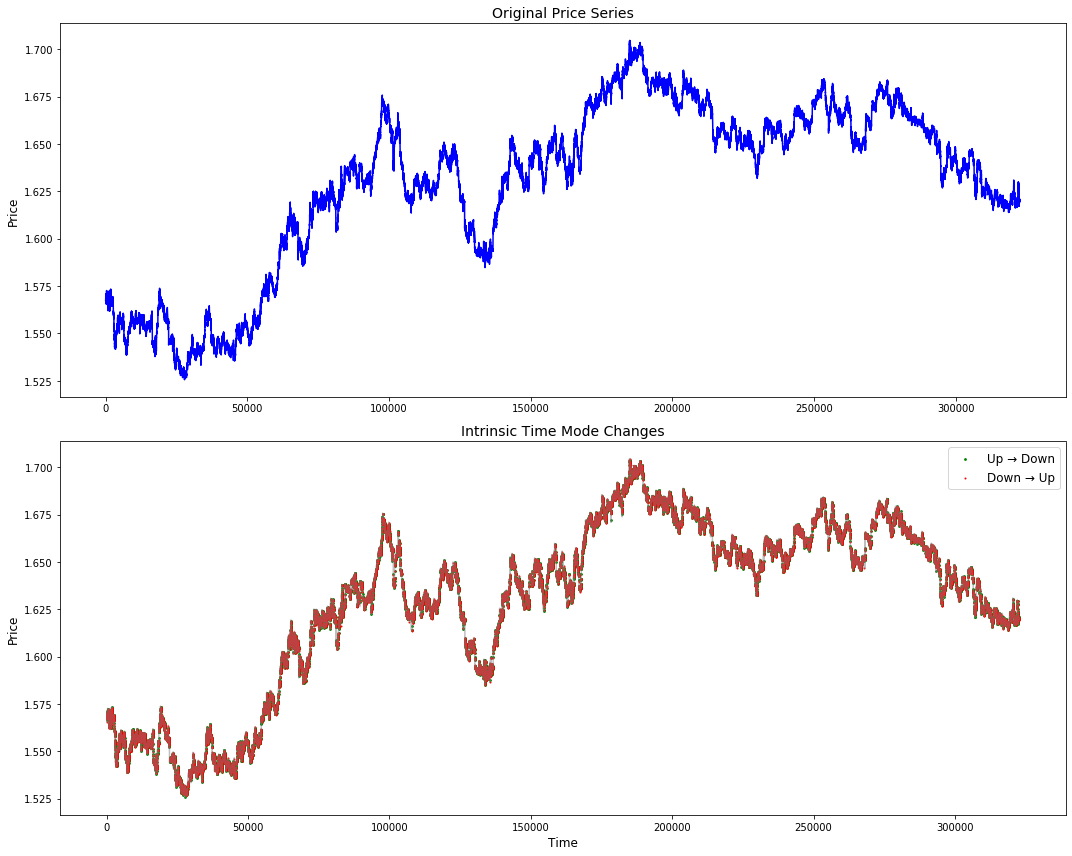

Trading halted after trade 905 due to capital depletion


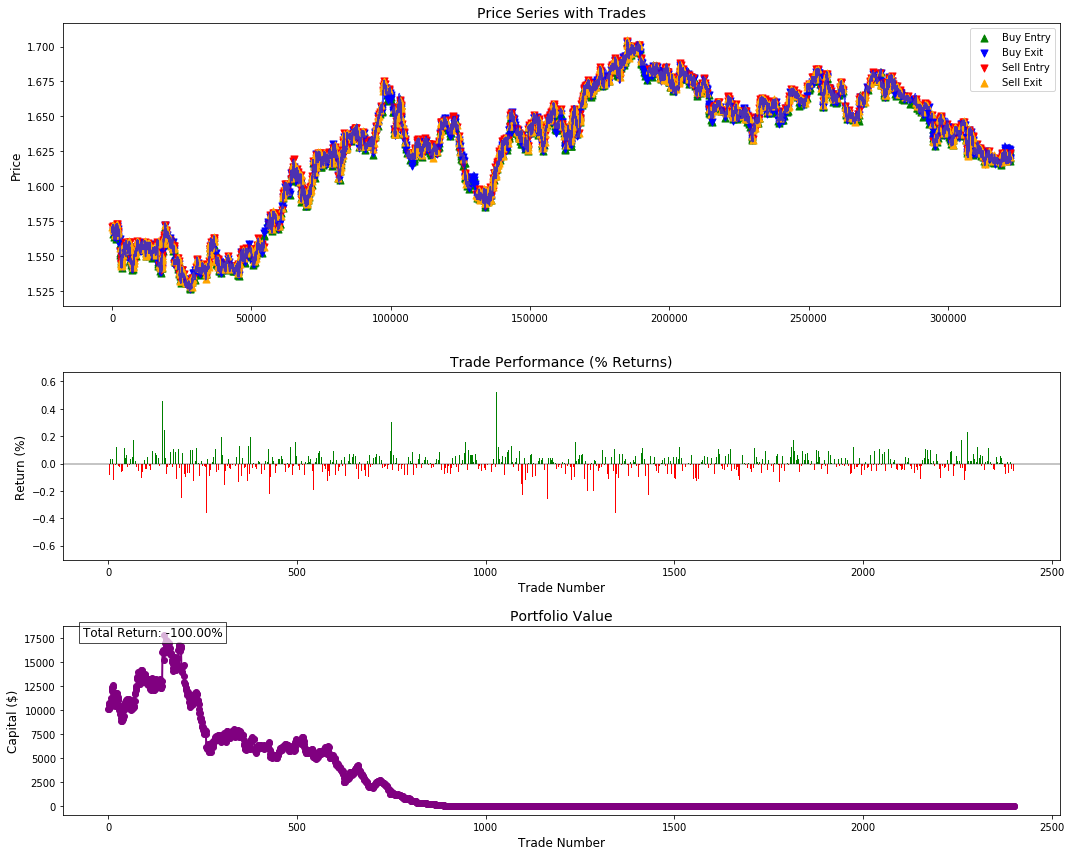


MEAN REVERSION TRADING STRATEGY SUMMARY
Total Trades: 2402
Winning Trades: 1256 (52.29%)
Average Win: 0.05%
Losing Trades: 1146 (47.71%)
Average Loss: -0.05%

Buy Trades: 1285
Buy Win Rate: 56.11%
Average Buy Profit: 0.01%

Sell Trades: 1117
Sell Win Rate: 47.90%
Average Sell Profit: -0.00%

Maximum Drawdown: $10000.00
Starting Capital: $10000.00
Final Capital: $0.00
Total Return: -100.00%

PROCESSING C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURCAD_M1_2023.xlsx


C:\Users\pc\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\pc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


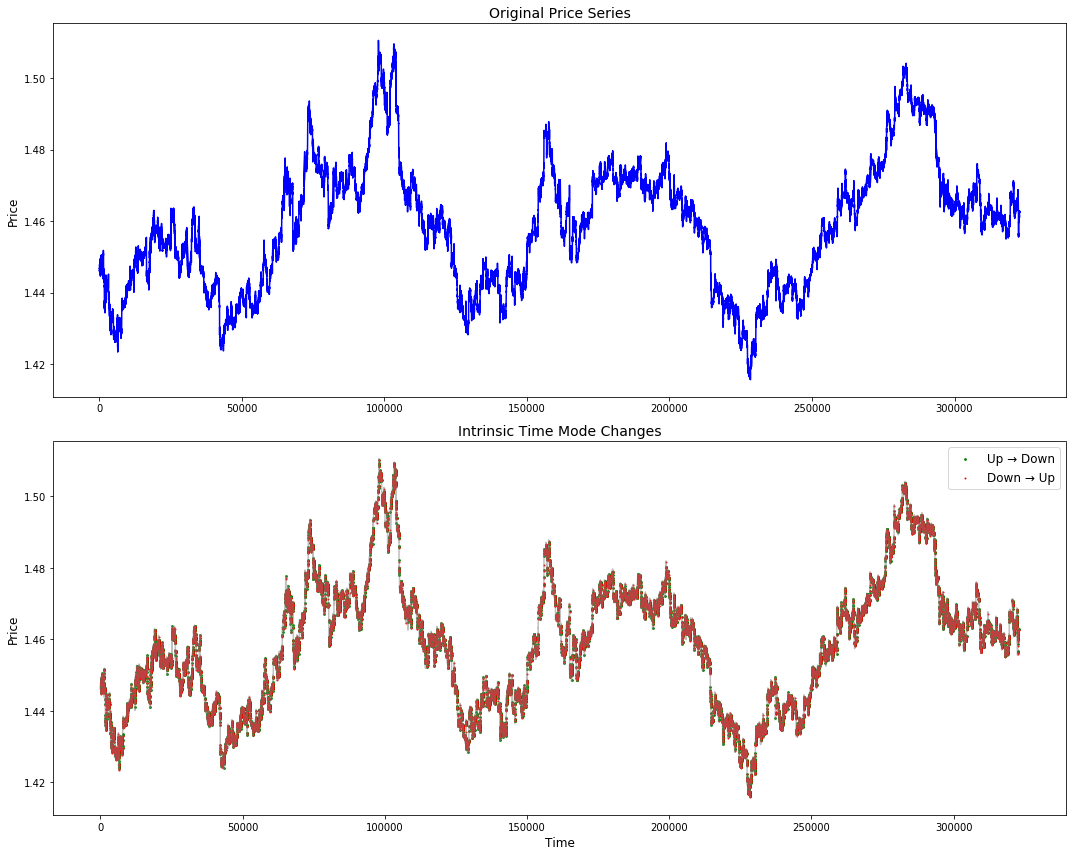

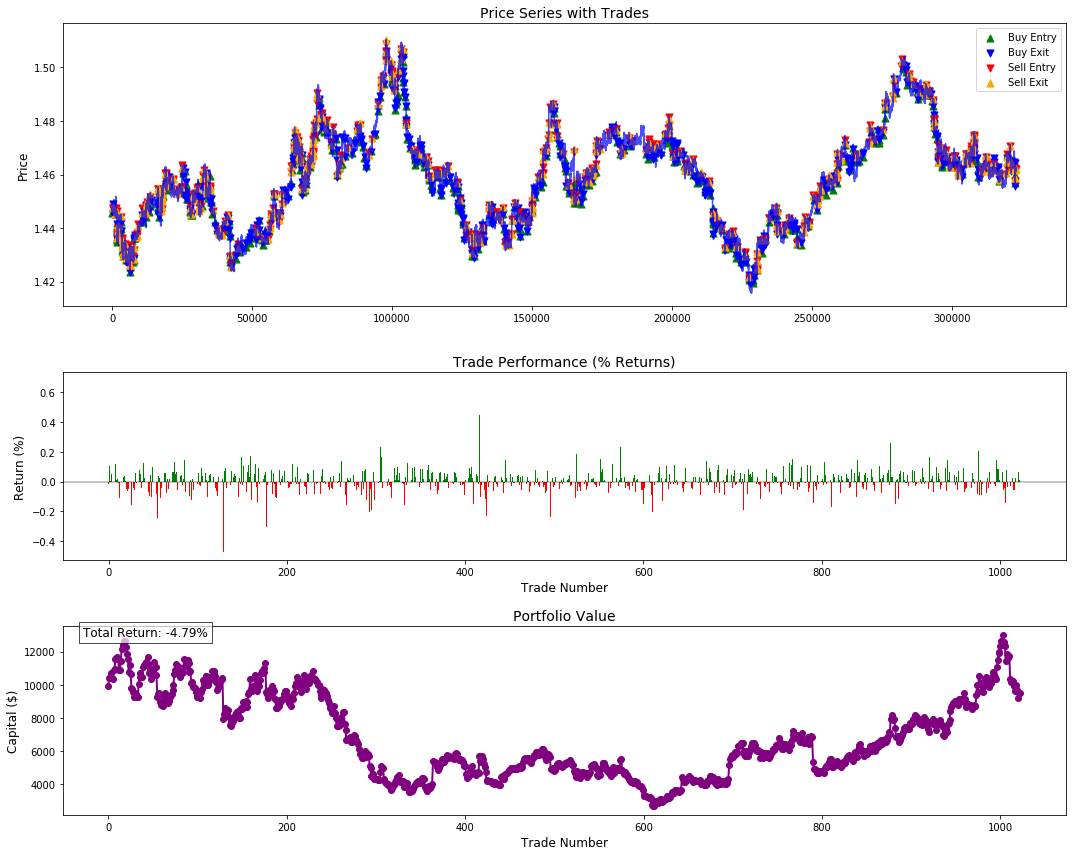


MEAN REVERSION TRADING STRATEGY SUMMARY
Total Trades: 1023
Winning Trades: 528 (51.61%)
Average Win: 0.06%
Losing Trades: 495 (48.39%)
Average Loss: -0.05%

Buy Trades: 598
Buy Win Rate: 55.02%
Average Buy Profit: 0.01%

Sell Trades: 425
Sell Win Rate: 46.82%
Average Sell Profit: -0.00%

Maximum Drawdown: $7332.87
Starting Capital: $10000.00
Final Capital: $9521.47
Total Return: -4.79%

PROCESSING C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURCHF_M1_2023.xlsx


C:\Users\pc\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\pc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


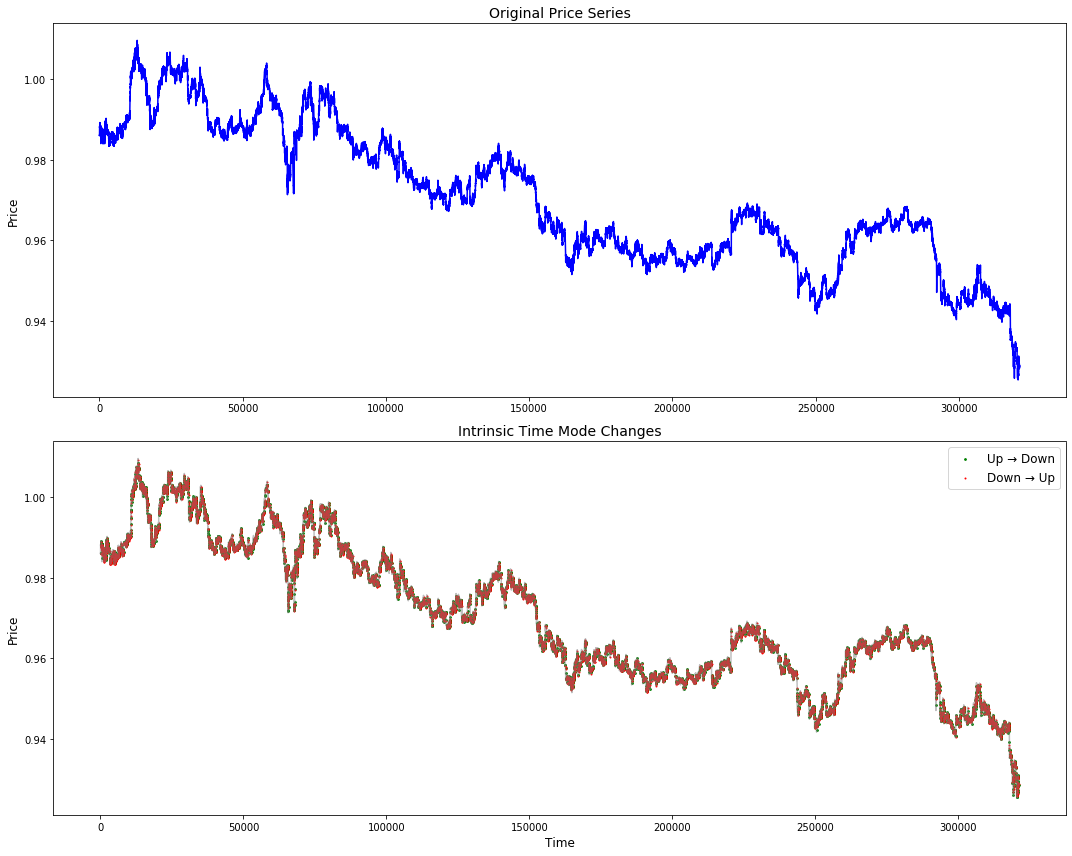

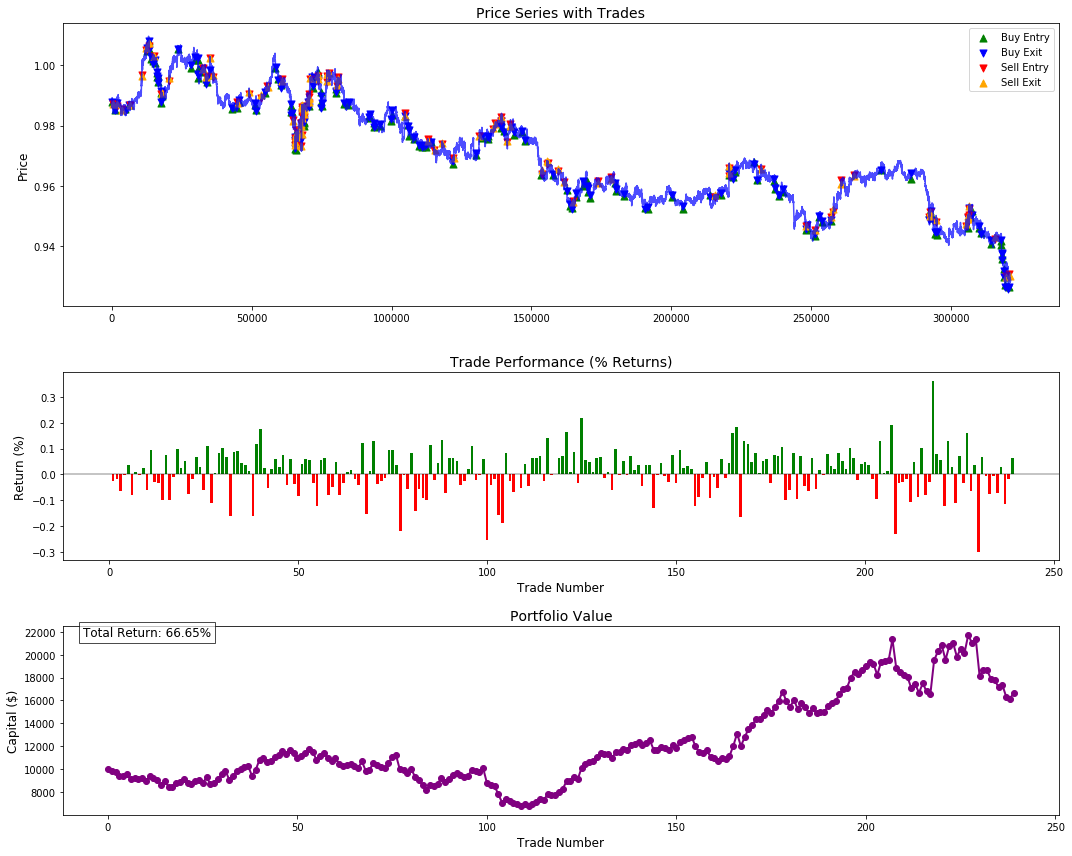


MEAN REVERSION TRADING STRATEGY SUMMARY
Total Trades: 240
Winning Trades: 131 (54.58%)
Average Win: 0.07%
Losing Trades: 109 (45.42%)
Average Loss: -0.06%

Buy Trades: 150
Buy Win Rate: 64.00%
Average Buy Profit: 0.02%

Sell Trades: 90
Sell Win Rate: 38.89%
Average Sell Profit: -0.01%

Maximum Drawdown: $3246.62
Starting Capital: $10000.00
Final Capital: $16664.82
Total Return: 66.65%


In [10]:
def process_multiple_files():
    # List of file paths to process
    file_paths = [
        r"C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURAUD_M1_2023.xlsx",  
        r"C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURCAD_M1_2023.xlsx",
        r"C:\Users\pc\OneDrive\College\HFT Files\DAT_XLSX_EURCHF_M1_2023.xlsx"
    ]
    
    # Process each file
    for i, file_path in enumerate(file_paths):
        currency_pair = file_path
        print(f"\n{'='*100}")
        print(f"PROCESSING {currency_pair}")
        print(f"{'='*100}")

        
        # Update the global FILE_PATH
        global FILE_PATH
        FILE_PATH = file_path
        
        # Load data
        price_series, original_df = load_data()
        
        # Convert to intrinsic time
        all_events_df, non_zero_events_df = convert_to_intrinsic_time(price_series)
        
        # Visualize intrinsic time conversion
        visualize_intrinsic_time(price_series, all_events_df, non_zero_events_df)
        
        # Apply trading strategy
        trades_df = apply_trading_strategy(all_events_df, original_df)
        
        # Backtest strategy
        portfolio_df = backtest_strategy(trades_df)
        
        # Visualize trading results
        visualize_trading_results(price_series, all_events_df, trades_df, portfolio_df)
        
        # Print summary
        print_summary(trades_df, portfolio_df)

if __name__ == "__main__":
    # Replace the main() call with process_multiple_files()
    process_multiple_files()

## Results

The results for the mean reversion strategy, including slippage and transaction costs, show big differences in performance across the three Euro currency pairs:

### Profitability and Capital Preservation:

- EUR/CHF: Substantial positive return of +66.65%.
- EUR/CAD: Marginal loss of -4.79%.
- EUR/AUD: Complete capital depletion with -100.00% return after 905 trades.


### RIsk and Drawdown Management:

- EUR/AUD: Maximum drawdown of 100% of capital.
- EUR/CAD: Almost disastrous drawdown of 73.3% of capital.
- EUR/CHF: Most 'controlled' drawdown of 32.5% of capital.



## Strategy Characteristics Analysis

### Trade Frequency Impact:

A clear inverse relationship exists between trade count and profitability:

- EUR/AUD: 2,402 trades → -100.00% return.
- EUR/CAD: 1,023 trades → -4.79% return.
- EUR/CHF: 240 trades → +66.65% return.


This strongly suggests that excessive trading is detrimental to performance. Unsurprisingly a mean reversion strategy is less likely to blow out in less volatile conditions such as the EUR/CHF pair compared to EUR/CAD. A factor here could also be the average trade size deployed - betting too much too soon invites the risk of a blow out. 


### Win Rate Consistency:

All pairs maintain similar win rates (51-55%).
However, the average profit per winning trade (0.05-0.07%) is only sufficient to overcome. transaction costs in the least-traded pair.


### Directional Bias:

Consistent outperformance of buy signals across all currency pairs:

- EUR/CHF buy win rate: 64.00% vs. sell win rate: 38.89%.
- EUR/AUD buy win rate: 56.11% vs. sell win rate: 47.90%.
- EUR/CAD buy win rate: 55.02% vs. sell win rate: 46.82%.

Average profits are consistently higher for buy trades than sell trades.



## Strategic Implications and Recommendations

- Trade Selectivity: The results provide compelling evidence that trade frequency is a factor, with fewer trades correlating strongly with better performance in this specific comparison.
- Volatility: EUR/CHF demonstrates significantly lower volatility than the other two currency pairs, unsurprisingly resulting in better results for a mean-reversion strategy.
- Directional Trading: The consistent outperformance of buy signals suggests a long-only approach could substantially improve results across the tested pairs.
- Risk Management Refinement: The wide variance in drawdowns indicates the need for pair-specific (or volatility-specific) position sizing and risk controls.

### Suggested Modifications:

- Increased event thresholds (DELTA_UP and DELTA_DOWN parameters) to reduce trade frequency.
- Focus primarily on EUR/CHF or similarly low-volatility pairs.
- Consider a long-only version of the strategy.



## Conclusion

The intrinsic time-based mean reversion strategy shows potential. EUR/CHF's substantial positive return demonstrates that, in spite of accounting for slippage and transaction costs, the core concept is viable under these specific parameter settings.

The stark performance disparity between currency pairs shows the impact of volatility and trade sizing in a mean-reversion strategy. 

These results highlight the challenges of this mean reversion approach and the potential for profitability with appropriate constraints and implementation.